# Setup

In [1]:
import sys  
sys.path.insert(0, '/home/ec2-user/SageMaker/efs/code/cad_llm')
import pandas as pd
import numpy as np
from pandas import DataFrame

In [ ]:
!pip install datasets torch transformers

# Load model and dataset

In [2]:
val_dataset_path = "/home/ec2-user/SageMaker/efs/data/sg_strings/sg_str_val.json"

# trained for 3 epochs
# finetune_checkpoint = "/home/ec2-user/SageMaker/efs/cad_llm_checkpoints/cad_llm_v1-02-01-23/checkpoint-270000/"
# train_new_checkpoint = "/home/ec2-user/SageMaker/efs/cad_llm_checkpoints/cad_llm_no_pretrain_v1-02-02-23/checkpoint-270000/"

# smaller batches, trained for less than one epoch
# v0_train_new_checkpoint = "/home/ec2-user/SageMaker/efs/cad_llm_checkpoints/01-24-23-no-pretraining/checkpoint-400000/"
# v0_finetune_checkpoint = "/home/ec2-user/SageMaker/efs/cad_llm_checkpoints/01-24-23-finetune-half-epoch/checkpoint-200000"

# no_pretrain_load_checkpoint = "/home/ec2-user/SageMaker/efs/cad_llm_checkpoint/01-24-23/checkpoint-400000" 
# load_checkpoint = "/home/ec2-user/SageMaker/efs/cad_llm_checkpoints/01-24-23/checkpoint-200000"

# all_ents_new_tokens_checkpoint = "/home/ec2-user/SageMaker/efs/cad_llm_checkpoints/cad_llm_v1_all_ents_q_tkz_const_lr-02-17-23/checkpoint-265000"

all_ents_checkpoint = "/home/ec2-user/SageMaker/efs/cad_llm_checkpoints/cad_llm_v1_all_ents-02-15-23/checkpoint-410000"

In [3]:
from models.byt5 import get_byt5_model

tokenizer, model = get_byt5_model(all_ents_checkpoint)
model.to("cuda")
print("Done")

Done


In [4]:
from dataset.sg_dataset import SketchGraphsDataset, SketchGraphsCollator
from torch.utils.data import DataLoader

val_dataset = SketchGraphsDataset(val_dataset_path)
data_collator = SketchGraphsCollator(tokenizer, max_length=128)

batch_size = 64
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=data_collator)

# Evaluate

## Sample from model

In [ ]:
from tqdm import tqdm

all_samples = []
for batch in tqdm(val_dataloader):
    labels = batch["labels"].to("cuda")
    samples = model.generate(input_ids=batch["input_ids"].to("cuda"),
                             attention_mask=batch["attention_mask"].to("cuda"),
                             do_sample=False,
                             max_new_tokens=labels.shape[1])
    all_samples += samples

 17%|█▋        | 104/615 [03:49<19:36,  2.30s/it]

## Process samples

In [11]:
columns=["ent_count", "missing_ent_count", "percent_hidden", "sample_ent_count", "matching_ent_count"]
info = []

def get_entities_from_sample(tokens):
    decoded = tokenizer.batch_decode([tokens], skip_special_tokens=True)[0]
    entities = [s + ';' for s in decoded.split(';') if s]
    return entities

for i, sample in enumerate(tqdm(all_samples)):
    sketch = val_dataset.get_sketch(index=i)
    i += 1
    label_ents = set([ent for j, ent in enumerate(sketch["entities"]) if not sketch["mask"][j]])
    sample_ents = set(get_entities_from_sample(sample))
    intersection = sample_ents.intersection(label_ents)
    
    info.append([
        len(sketch["entities"]), 
        len(label_ents),
        len(label_ents) / len(sketch["entities"]),
        len(sample_ents),
        len(intersection),
    ])
    
df = pd.DataFrame(info, columns=columns)

100%|██████████| 39344/39344 [11:10<00:00, 58.68it/s]


In [12]:
df["percent_autocompleted"] = df.matching_ent_count / df.missing_ent_count
df["percent_useful"] = df.matching_ent_count / df.sample_ent_count
df["any_autocompleted"] = (df.matching_ent_count >= 1)
df["all_autocompleted"] = (df.matching_ent_count == df.missing_ent_count)
df["exact_match"] = (df.matching_ent_count == df.missing_ent_count) & (df.sample_ent_count == df.missing_ent_count)
df["bucket_percent_hidden"] = df.percent_hidden.round(decimals=1)

In [14]:
df.head()

,ent_count,missing_ent_count,percent_hidden,sample_ent_count,matching_ent_count,percent_autocompleted,percent_useful,any_autocompleted,all_autocompleted,exact_match,bucket_percent_hidden
0,8,3,0.375000,4,3,1.00,0.750000,True,True,False,0.4
1,4,1,0.250000,4,1,1.00,0.250000,True,True,False,0.2
2,3,1,0.333333,2,0,0.00,0.000000,False,False,False,0.3
3,16,4,0.250000,4,3,0.75,0.750000,True,False,False,0.2
4,2,1,0.500000,6,1,1.00,0.166667,True,True,False,0.5


# Visualize

In [40]:
print("summary")
print(f"all_autocompleted: {df.all_autocompleted.mean()*100:.2f}%")
print(f"any_autocompleted: {df.any_autocompleted.mean()*100:.2f}%")
print(f"percent_autocompleted: {df.percent_autocompleted.mean()*100:.2f}%")
print(f"percent_useful: {df.percent_useful.mean()*100:.2f}%")
print(f"exact_match: {df.exact_match.mean()*100:.2f}%")

summary
all_autocompleted: 27.68%
any_autocompleted: 65.47%
percent_autocompleted: 42.93%
percent_useful: 39.77%
exact_match: 16.25%


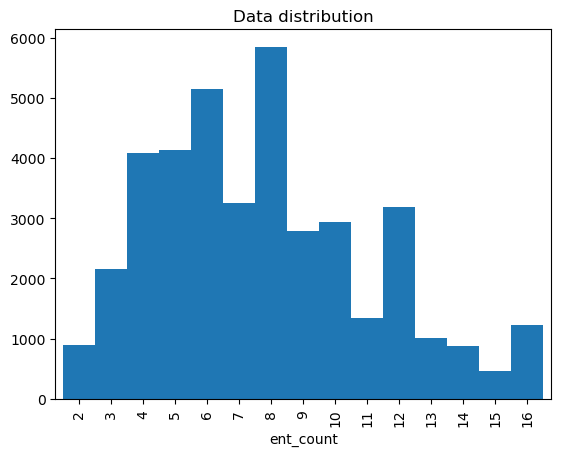

In [23]:
_ = df.groupby("ent_count").size().plot.bar(title="Data distribution", width=1.0)

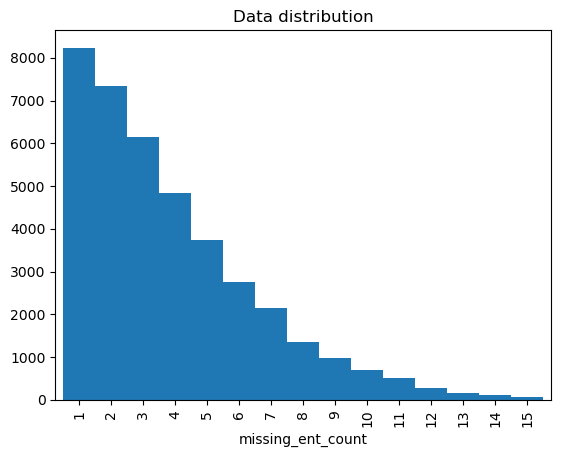

In [24]:
_ = df.groupby("missing_ent_count").size().plot.bar(title="Data distribution", width=1.0)

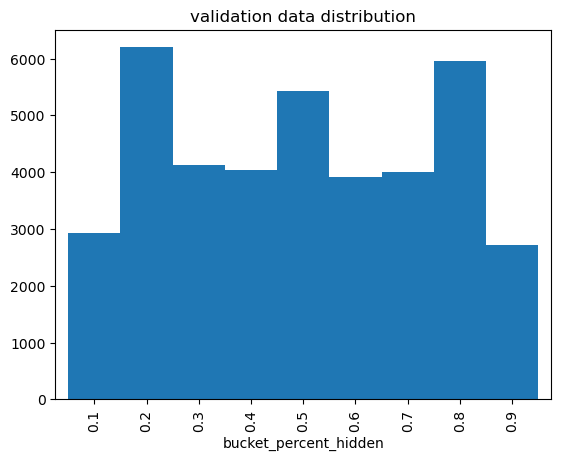

In [39]:
_ = df.groupby("bucket_percent_hidden").size().plot.bar(title="validation data distribution", width=1.0)

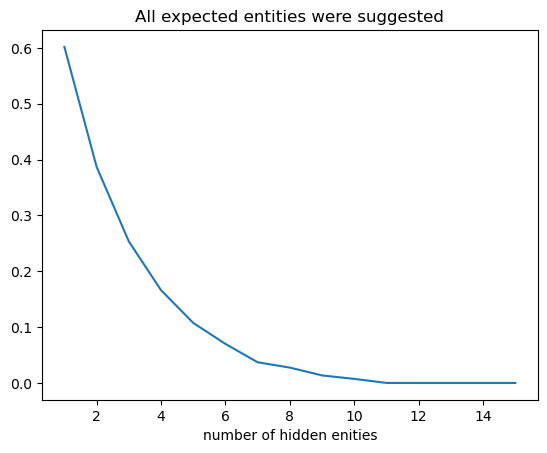

In [25]:
_ = df.groupby("missing_ent_count").all_autocompleted.mean().plot(title="All expected entities were suggested", xlabel="number of hidden enities")

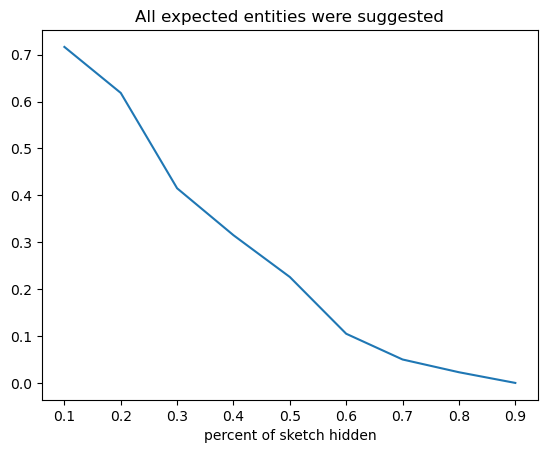

In [26]:
_ = df.groupby("bucket_percent_hidden").all_autocompleted.mean().plot(title="All expected entities were suggested", xlabel="percent of sketch hidden")

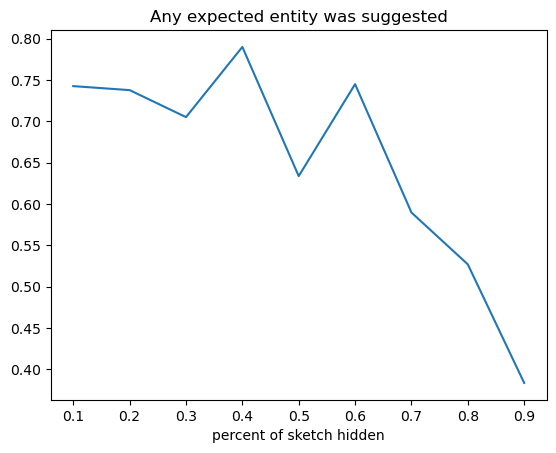

In [34]:
_ = df.groupby("bucket_percent_hidden").any_autocompleted.mean().plot(title="Any expected entity was suggested", xlabel="percent of sketch hidden")

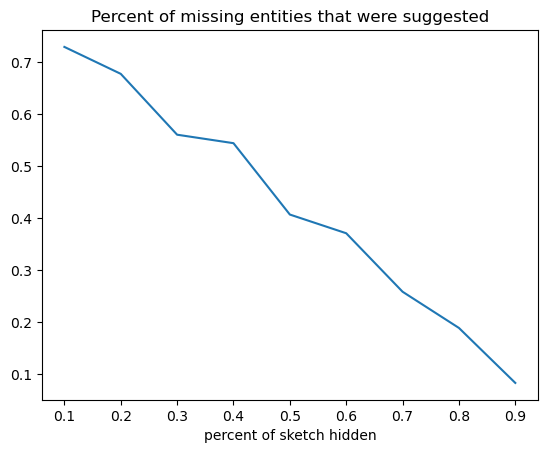

In [35]:
_ = df.groupby("bucket_percent_hidden").percent_autocompleted.mean().plot(title="Percent of missing entities that were suggested", xlabel="percent of sketch hidden")

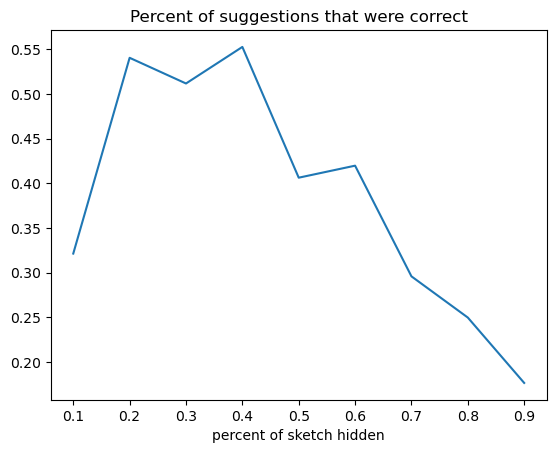

In [36]:
_ = df.groupby("bucket_percent_hidden").percent_useful.mean().plot(title="Percent of suggestions that were correct", xlabel="percent of sketch hidden")

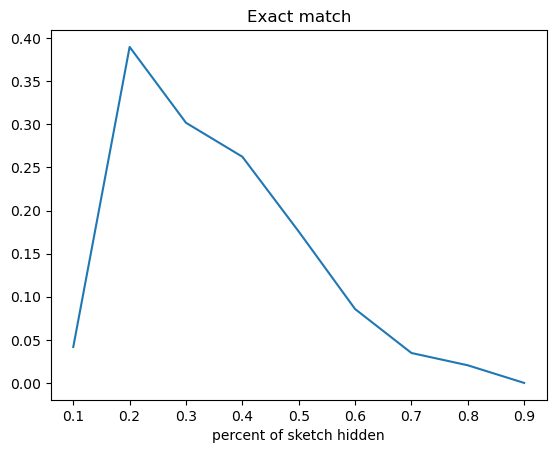

In [37]:
_ = df.groupby("bucket_percent_hidden").exact_match.mean().plot(title="Exact match", xlabel="percent of sketch hidden")

In [41]:
all_samples[0]

tensor([ 0, 48, 54, 52, 47, 54, 47, 58, 47, 54, 62, 58, 47, 54, 47, 58, 47, 60,
        62, 58, 47, 60, 47, 54, 52, 47, 60, 62, 54, 52, 47, 48, 54, 47, 54, 52,
        47, 60, 62,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0], device='cuda:0')